# Time Series Clustering

## Feature extraction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


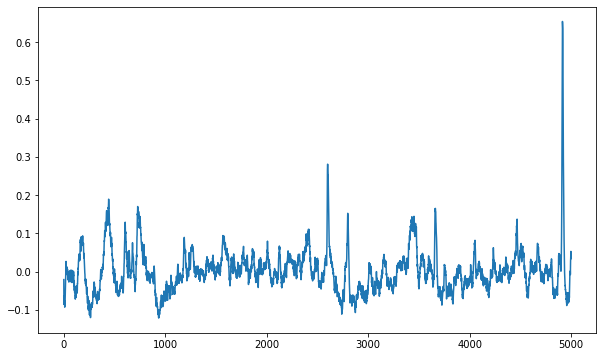

In [2]:
datapath = '../../Data/'

data = np.loadtxt(datapath+'tseries.csv')
fig = plt.figure(figsize=(10,6))
plt.plot(data);

Fast Fourier Tranform (space of frequencies)

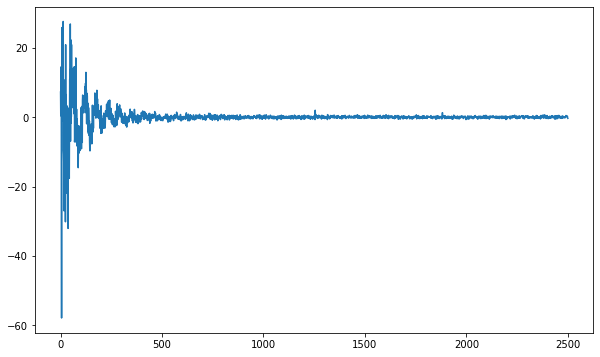

In [3]:
from numpy.fft import rfft

freq = rfft(data[0:5000])
fig = plt.figure(figsize=(10,6))
plt.plot(freq);

The **SAX** method generates a new discretized series 

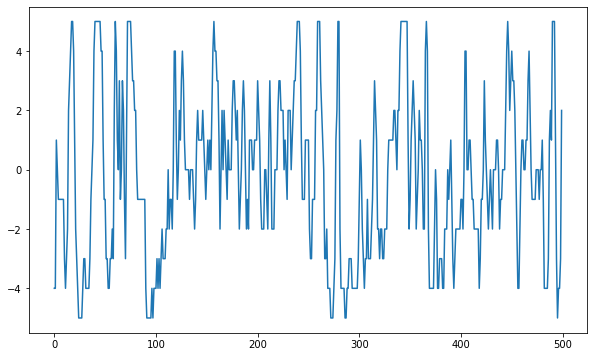

In [4]:
import kemlglearn.time_series.discretization.SAX as SAX
saxtrans = SAX(window_length=data.shape[0], word_length=500, voc_size=11)
datatrans = saxtrans.transform(data)
fig = plt.figure(figsize=(10,6))
plt.plot(datatrans[0]);

# Clustering Time Series

This data corresponds to recordings from cat's spinal cords

(60, 85)


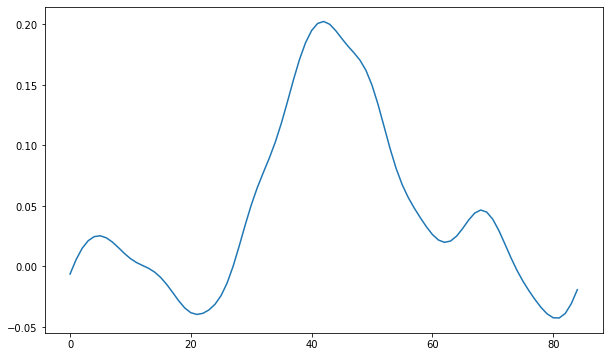

In [6]:
datapath = '../../Data/'

X = np.loadtxt(datapath+'peaks.csv', delimiter=' ')
print(X.shape)
fig = plt.figure(figsize=(10,6))
plt.plot(X[0]);

Clustering of the series using K-medoids and euclidean distance

In [7]:
from kemlglearn.cluster import KMedoidsFlexible
from scipy.spatial import distance

def sel(n, i, j):
    return n * i - (i * (i+1)//2) + (j - i) - 1

nc = 4
mdist = np.zeros(X.shape[0] * (X.shape[0] - 1) // 2)

In [8]:
%%timeit -n1 -r1
for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        mdist[sel(X.shape[0], i, j)] = distance.euclidean(X[i], X[j])

82.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
km = KMedoidsFlexible(n_clusters=nc, distance='precomputed')
labels_euc = km.fit_predict(mdist)

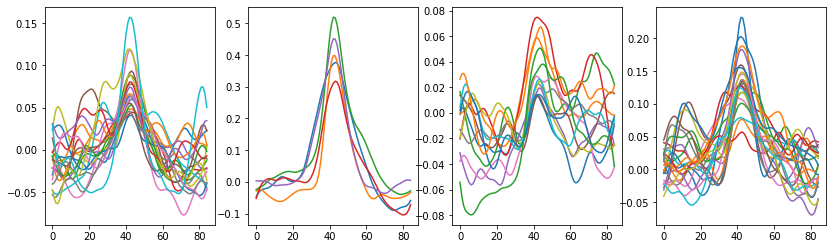

In [10]:
fig = plt.figure(figsize=(14,4))
for i in range(nc):
    ax = fig.add_subplot(1, nc, i + 1)
    for p, j in enumerate(labels_euc):
        if j == i:
            ax.plot(X[p])
plt.show();

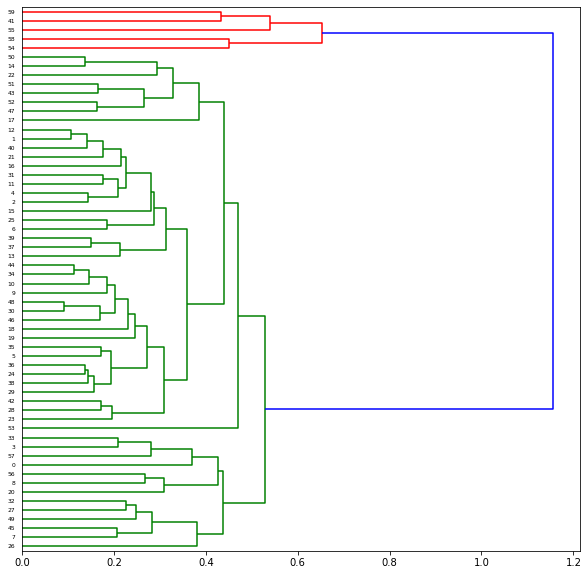

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clust = linkage(mdist, method='average')
plt.figure(figsize=(10,10))
dendrogram(clust, distance_sort=True, orientation='right');


Clustering of the series using K-medoids and DTW distance

In [12]:
from fastdtw import fastdtw
mdist = np.zeros(X.shape[0] * (X.shape[0] - 1) // 2)

In [13]:
%%timeit -n1 -r1
for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        mdist[sel(X.shape[0], i, j)] = fastdtw(X[i], X[j], dist=distance.euclidean)[0]

2min 11s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
km = KMedoidsFlexible(n_clusters=nc, distance='precomputed')
labels_dtw = km.fit_predict(mdist)

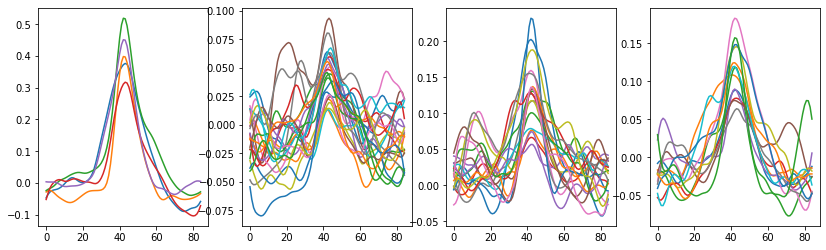

In [15]:
fig = plt.figure(figsize=(14,4))
for i in range(nc):
    ax = fig.add_subplot(1, nc, i + 1)
    for p, j in enumerate(labels_dtw):
        if j == i:
            ax.plot(X[p])
plt.show();

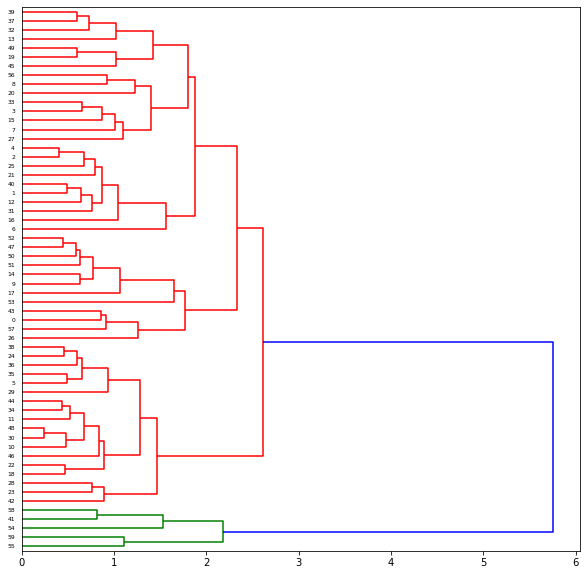

In [16]:
clust = linkage(mdist, method='average')
plt.figure(figsize=(10,10))
dendrogram(clust, distance_sort=True, orientation='right');

Clustering of the series using K-medoids and euclidean distance using SAX

(60, 20)


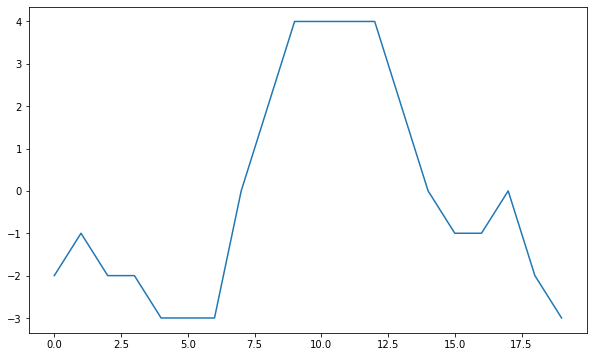

In [17]:
tmp = []

wordl= 20
saxtrans = SAX(window_length=X.shape[1], word_length=wordl, voc_size=9)
SAXX = np.zeros((X.shape[0],wordl))
for i in range(X.shape[0]):
    SAXX[i,:] =saxtrans.transform(X[i])[0]

print(SAXX.shape)
fig = plt.figure(figsize=(10,6))
plt.plot(SAXX[0]);

In [18]:
mdist = np.zeros(X.shape[0] * (X.shape[0] - 1) // 2)

In [19]:
%%timeit -n1 -r1
for i in range(SAXX.shape[0]):
    for j in range(i+1, SAXX.shape[0]):
        mdist[sel(SAXX.shape[0], i, j)] = distance.euclidean(SAXX[i], SAXX[j])

76 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
km = KMedoidsFlexible(n_clusters=nc, distance='precomputed')
labels_saxeuc = km.fit_predict(mdist)

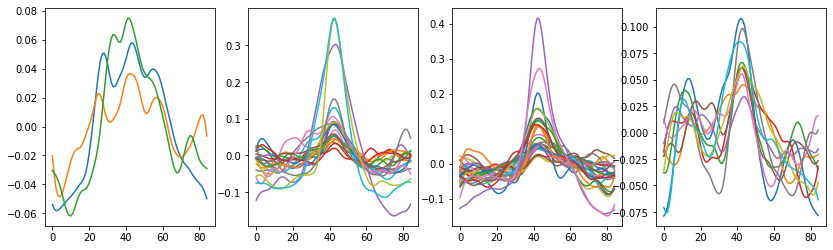

In [21]:
fig = plt.figure(figsize=(14,4))
for i in range(nc):
    ax = fig.add_subplot(1, nc, i + 1)
    for p, j in enumerate(labels_saxeuc):
        if j == i:
            ax.plot(X[p])
plt.show();

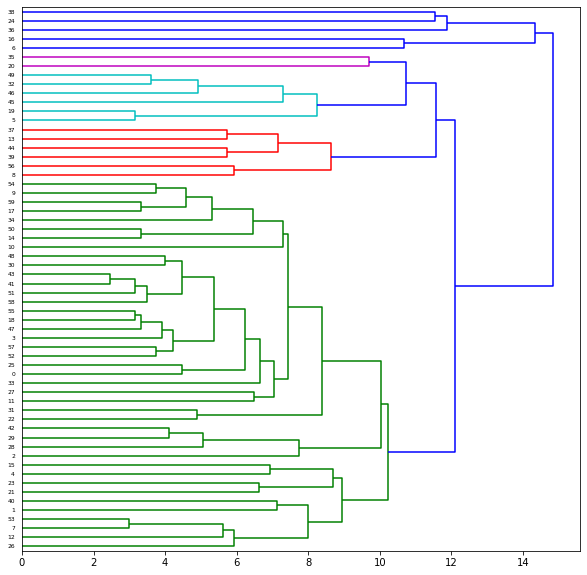

In [22]:
clust = linkage(mdist, method='average')
plt.figure(figsize=(10,10))
dendrogram(clust, distance_sort=True, orientation='right');